In [1]:
#  Aula Prática – Integração entre PostgreSQL (Pagila) e APIs com Python

# Nesta atividade, você irá:
# - Consultar dados da base Pagila com `psycopg2`
# - Integrar dados climáticos e populacionais usando APIs externas
# - Analisar, transformar e visualizar os dados
# - Praticar o uso de Pandas, APIs, SQL e operações avançadas como `lambda`, `groupby`, `merge`, entre outras

In [2]:
# Imports e Configurações Iniciais
import os
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import requests
import seaborn as sns
from dotenv import load_dotenv
from tabulate import tabulate
import numpy as np # Adicionado para simulações e operações numéricas
import time # Para throttling opcional de API

In [3]:
# Carregar variáveis de ambiente do arquivo .env
load_dotenv()

# Obter as variáveis de ambiente para conexão com o banco
db = os.getenv("PG_DB")
user = os.getenv("PG_USER")
password = os.getenv("PG_PASSWORD")
host = os.getenv("PG_HOST")
port = os.getenv("PG_PORT")
sslmode = os.getenv("PG_SSLMODE")


# Chaves de API (serão usadas pelas funções de busca)
WEATHER_API_KEY = os.getenv("WEATHER_KEY")
AIRVISUAL_API_KEY = os.getenv("AIRVISUAL_KEY")

# Estabelecer conexão com o PostgreSQL
try:
    conn = psycopg2.connect(
        dbname=db, user=user, password=password, host=host, port=port, sslmode=sslmode
    )
    cur = conn.cursor()
    cur.execute("SELECT VERSION()")
    version = cur.fetchone()[0]
    print(f"PostgreSQL version: {version}")
    # cur.close() # Fechar o cursor aqui se não for mais usá-lo globalmente logo em seguida
except Exception as e:
    print(f"Erro ao conectar ao PostgreSQL: {e}")
    conn = None # Define conn como None se a conexão falhar




PostgreSQL version: PostgreSQL 16.8 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 14.2.1 20240912 (Red Hat 14.2.1-3), 64-bit


In [4]:
# Funções de API (Originais e com Cache - Implementação do Exercício 10 será integrada aqui)
def run_query(sql, db_conn=conn):
    """
    Executes a SQL query on the provided database connection and returns the result as a DataFrame.
    """
    if db_conn is None:
        print("Conexão com o banco de dados não está disponível.")
        return pd.DataFrame() # Retorna DataFrame vazio
    try:
        return pd.read_sql_query(sql, db_conn)
    except Exception as e:
        print(f"Erro ao executar query: {e}")
        return pd.DataFrame()

In [5]:
# --- Configuração do Cache (para Exercício 10) ---
CACHE_DIR = "api_cache"
WEATHER_CACHE_FILE = os.path.join(CACHE_DIR, "weather_cache.csv")
AQI_CACHE_FILE = os.path.join(CACHE_DIR, "aqi_cache.csv")
COUNTRIES_CACHE_FILE = os.path.join(CACHE_DIR, "countries_cache.csv")

if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

# --- Funções de Cache Genéricas ---
def carregar_cache_csv(filepath, key_col, value_col):
    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath)
            # Tratar NaNs que podem ser lidos como strings
            df[value_col] = df[value_col].replace({'nan': np.nan, 'None': np.nan})
            return df.set_index(key_col)[value_col].to_dict()
        except pd.errors.EmptyDataError:
            return {}
        except Exception as e:
            print(f"Erro ao carregar cache de {filepath}: {e}")
            return {}
    return {}

def salvar_cache_csv(cache_data, filepath, key_name, value_name):
    try:
        pd.DataFrame(list(cache_data.items()), columns=[key_name, value_name]).to_csv(filepath, index=False)
    except Exception as e:
        print(f"Erro ao salvar cache em {filepath}: {e}")




In [6]:
def _buscar_clima_api(cidade): # Função "privada" que realmente chama a API
    if not WEATHER_API_KEY:
        # print("Chave da API WeatherAPI (WEATHER_KEY) não configurada.")
        return None
    try:
        url = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={cidade}&aqi=no"
        resposta = requests.get(url, timeout=10)
        resposta.raise_for_status()
        dados = resposta.json()
        if "current" in dados and "temp_c" in dados["current"]:
            return dados["current"]["temp_c"]
        else:
            # print(f"Dados de temperatura não encontrados para {cidade} na resposta da API.")
            return None
    except requests.exceptions.HTTPError as http_err:
        # print(f"Erro HTTP ao buscar clima para {cidade}: {http_err.response.status_code}")
        return None
    except requests.exceptions.RequestException: # Outros erros de request
        # print(f"Erro na requisição ao buscar clima para {cidade}: {req_err}")
        return None
    except Exception: # Erro genérico (ex: parsing JSON)
        # print(f"Erro inesperado ao buscar clima para {cidade}: {e}")
        return None
# --- Cache para WeatherAPI ---
weather_cache = carregar_cache_csv(WEATHER_CACHE_FILE, 'city_query', 'temperatura')

def buscar_clima(cidade): # Função pública que usa o cache
    global weather_cache
    if pd.isna(cidade) or cidade == "":
        return None
    cidade_query_key = str(cidade).lower()

    if cidade_query_key in weather_cache:
        cached_value = weather_cache[cidade_query_key]
        if not pd.isna(cached_value): # Só retorna se não for NaN explicitamente cacheado
            # print(f"CACHE HIT (Clima): {cidade}")
            return float(cached_value)
        # Se for NaN cacheado, significa que já tentamos e falhou, então não tentamos de novo (a menos que a lógica mude)

    # print(f"API CALL (Clima): {cidade}")
    time.sleep(0.1) # Pequeno delay para não sobrecarregar API
    temperatura = _buscar_clima_api(cidade)
    
    weather_cache[cidade_query_key] = float(temperatura) if temperatura is not None else np.nan
    salvar_cache_csv(weather_cache, WEATHER_CACHE_FILE, 'city_query', 'temperatura')
    return temperatura

# Exemplo de teste
cidade = "Brasília"
print(f"A temperatura atual em {cidade} é de {buscar_clima(cidade)}°C")

A temperatura atual em Brasília é de 19.0°C


In [7]:
# --- Cache para AirVisual API ---
aqi_cache = carregar_cache_csv(AQI_CACHE_FILE, 'location_query', 'aqi')

def _buscar_aqi_cidade_api(cidade, estado, pais):
    if not AIRVISUAL_API_KEY:
        # print("Chave da API AirVisual (AIRVISUAL_KEY) não configurada.")
        return None
    try:
        # Tentar normalizar nomes para a API AirVisual, especialmente país
        pais_api = pais # Pode precisar de mapeamento mais robusto (ver Ex4)
        
        url = f"http://api.airvisual.com/v2/city?city={requests.utils.quote(cidade)}&state={requests.utils.quote(estado)}&country={requests.utils.quote(pais_api)}&key={AIRVISUAL_API_KEY}"
        resposta = requests.get(url, timeout=15)
        resposta.raise_for_status()
        dados = resposta.json()
        if dados.get("status") == "success" and dados.get("data", {}).get("current", {}).get("pollution"):
            return dados["data"]["current"]["pollution"]["aqius"]
        else:
            # print(f"Dados de AQI não encontrados para {cidade}, {estado}, {pais_api}. Status: {dados.get('status')}, Msg: {dados.get('data', {}).get('message')}")
            return None
    except requests.exceptions.HTTPError as http_err:
        # print(f"Erro HTTP ao buscar AQI para {cidade}, {estado}, {pais}: {http_err.response.status_code}")
        return None
    except requests.exceptions.RequestException:
        # print(f"Erro na requisição ao buscar AQI para {cidade}, {estado}, {pais}: {req_err}")
        return None
    except Exception:
        # print(f"Erro inesperado ao buscar AQI para {cidade}, {estado}, {pais}: {e}")
        return None
    
def buscar_aqi_cidade(cidade, estado, pais):
    global aqi_cache
    if pd.isna(cidade) or pd.isna(estado) or pd.isna(pais) or "" in [cidade, estado, pais]:
        return None
        
    location_query_key = f"{str(cidade).lower()}|{str(estado).lower()}|{str(pais).lower()}"

    if location_query_key in aqi_cache:
        cached_value = aqi_cache[location_query_key]
        if not pd.isna(cached_value):
            # print(f"CACHE HIT (AQI): {location_query_key.replace('|',', ')}")
            return float(cached_value)

    # print(f"API CALL (AQI): {cidade}, {estado}, {pais}")
    time.sleep(0.2) # AirVisual pode ser mais sensível a rate limits
    aqi = _buscar_aqi_cidade_api(cidade, estado, pais)
    
    aqi_cache[location_query_key] = float(aqi) if aqi is not None else np.nan
    salvar_cache_csv(aqi_cache, AQI_CACHE_FILE, 'location_query', 'aqi')
    return aqi

# Exemplo de teste
cidade = "são paulo"
estado = "sao paulo"
pais = "Brazil"
print(f"O AQI atual em {cidade}, {estado}, {pais} é de {buscar_aqi_cidade(cidade, estado, pais)}")

O AQI atual em são paulo, sao paulo, Brazil é de 69.0


In [8]:
# --- Cache para REST Countries API ---

# Para countries_cache, o valor é um dicionário, então o tratamento é um pouco diferente.
def carregar_cache_paises():
    if os.path.exists(COUNTRIES_CACHE_FILE):
        try:
            df = pd.read_csv(COUNTRIES_CACHE_FILE)
            cache = {}
            for _, row in df.iterrows():
                country_key = row['country_query']
                data_val = row['data']
                if pd.notna(data_val) and str(data_val).lower() not in ['nan', 'none']:
                    try:
                        cache[country_key] = eval(data_val) # eval pode ser arriscado; use json.loads se o dado for JSON string
                    except: # se eval falhar
                        cache[country_key] = None # ou algum marcador de erro
                else:
                    cache[country_key] = None # Representa um None/NaN que foi explicitamente cacheado
            return cache
        except pd.errors.EmptyDataError: return {}
        except Exception as e:
            print(f"Erro ao carregar cache de países: {e}")
            return {}
    return {}


def salvar_cache_paises(cache_data):
    try:
        df_list = []
        for key, value in cache_data.items():
            df_list.append({'country_query': key, 'data': str(value) if value is not None else None}) # Salvar como string
        pd.DataFrame(df_list).to_csv(COUNTRIES_CACHE_FILE, index=False)
    except Exception as e:
        print(f"Erro ao salvar cache de países: {e}")


paises_cache = carregar_cache_paises()

# Mapeamento de nomes de países (Pagila -> API RESTCountries)
country_name_map_rest = {
    "United States": "United States of America",
    "Iran (Islamic Republic of)": "Iran",
    "Russian Federation": "Russia",
    "Czech Republic": "Czechia",
    "Korea (South)": "South Korea", "Korea, Republic of": "South Korea",
    "Macedonia": "North Macedonia",
    "Taiwan": "Taiwan",
    "Viet Nam": "Vietnam",
    "Congo (Dem. Rep.)": "Democratic Republic of the Congo", "Congo, The Democratic Republic of the": "Democratic Republic of the Congo",
    "Holy See (Vatican City State)": "Vatican City",
    "RUNION": "Réunion", # Pagila parece ter "RUNION" para "Réunion"
    "Brasil": "Brazil", # Adicionado para evitar problemas de mapeamento
}

def _buscar_dados_pais_api(nome_pais_api):
    try:
        url = f"https://restcountries.com/v3.1/name/{requests.utils.quote(nome_pais_api)}?fullText=false"
        resposta = requests.get(url, timeout=10)
        resposta.raise_for_status()
        dados_pais_lista = resposta.json()
        
        if dados_pais_lista:
            # Tentar encontrar o melhor match ou pegar o primeiro com os dados esperados
            for pais_info in dados_pais_lista:
                if 'population' in pais_info and 'name' in pais_info:
                    return {
                        'name_common': pais_info['name'].get('common', nome_pais_api),
                        'name_official': pais_info['name'].get('official', nome_pais_api),
                        'population': pais_info.get('population'),
                        'region': pais_info.get('region'), # Continente
                        'subregion': pais_info.get('subregion')
                    }
            # Fallback se não encontrar um match ideal, mas ainda tiver dados
            if dados_pais_lista[0]:
                return {
                    'name_common': dados_pais_lista[0]['name'].get('common', nome_pais_api),
                    'name_official': dados_pais_lista[0]['name'].get('official', nome_pais_api),
                    'population': dados_pais_lista[0].get('population'),
                    'region': dados_pais_lista[0].get('region'),
                    'subregion': dados_pais_lista[0].get('subregion')
                }
        # print(f"Dados não encontrados ou incompletos para o país na API: {nome_pais_api}")
        return None
    except requests.exceptions.HTTPError as http_err:
        # if http_err.response.status_code == 404:
            # print(f"País não encontrado na API REST Countries: {nome_pais_api}")
        # else:
            # print(f"Erro HTTP ao buscar dados para {nome_pais_api}: {http_err.response.status_code}")
        return None
    except requests.exceptions.RequestException: # Outros erros de request
        # print(f"Erro na requisição ao buscar dados para {nome_pais_api}: {req_err}")
        return None
    except Exception: # Erro genérico
        # print(f"Erro inesperado ao buscar dados para {nome_pais_api}: {e}")
        return None
    

def buscar_dados_pais(nome_pais_pagila):
    global paises_cache
    if pd.isna(nome_pais_pagila) or nome_pais_pagila == "":
        return None

    nome_pais_query_key = str(nome_pais_pagila).lower()
    nome_pais_api = country_name_map_rest.get(nome_pais_pagila, nome_pais_pagila) # Usar nome mapeado se existir

    if nome_pais_query_key in paises_cache:
        cached_value = paises_cache[nome_pais_query_key]
        if cached_value is not None: # Se não for o None explicitamente cacheado
            # print(f"CACHE HIT (País): {nome_pais_pagila} -> {nome_pais_api}")
            return cached_value
        # Se for None cacheado, já tentamos e falhou

    # print(f"API CALL (País): {nome_pais_pagila} -> {nome_pais_api}")
    time.sleep(0.1)
    dados = _buscar_dados_pais_api(nome_pais_api)
    
    paises_cache[nome_pais_query_key] = dados # Cacheia o dicionário ou None
    salvar_cache_paises(paises_cache)
    return dados

### Exercício 1 – Temperatura Média das Capitais dos Clientes

- Recupere as cidades dos clientes com mais de 10 transações.
- Use a WeatherAPI para buscar a temperatura atual dessas cidades.
- Calcule a temperatura média ponderada por número de clientes.
- Insight esperado: quais cidades concentram clientes e temperaturas extremas?


In [9]:
# Exercício 1 – Temperatura Média das Cidades dos Clientes (Corrigido para ponderação por NÚMERO DE CLIENTES)

print("\n--- Exercício 1: Temperatura Média das Cidades dos Clientes ---")

# 1. Recupere as cidades com mais de 10 transações totais e o número de clientes nessas cidades.
query_cidades_clientes_transacoes = """
SELECT
    ci.city,
    COUNT(DISTINCT c.customer_id) AS num_clientes,    -- Para a ponderação
    COUNT(p.payment_id) AS total_transacoes_cidade -- Para o critério de seleção da cidade
FROM city ci
    JOIN address a ON ci.city_id = a.city_id
    JOIN customer c ON a.address_id = c.address_id
    LEFT JOIN payment p ON c.customer_id = p.customer_id
GROUP BY ci.city
HAVING COUNT(p.payment_id) > 10 -- Cidades com mais de 10 transações no total
ORDER BY num_clientes DESC;     -- Ordenar por número de clientes para a amostra
"""
df_cidades_info = run_query(query_cidades_clientes_transacoes) # DataFrame com informações da cidade

if not df_cidades_info.empty:
    # 2. Use a WeatherAPI para buscar a temperatura atual de uma amostra dessas cidades.
    # df_cidades_info já está ordenado por num_clientes DESC devido à query SQL.
    amostra_cidades_ex1 = df_cidades_info.head(20).copy() # Pega as 20 cidades com mais clientes (que atendem ao critério de transações)

    print(f"Buscando clima para {len(amostra_cidades_ex1)} cidades (Ex1)...")
    amostra_cidades_ex1.loc[:, 'temperatura'] = amostra_cidades_ex1['city'].apply(buscar_clima)

    # Remove cidades para as quais não foi possível obter temperatura e converte para numérico
    df_analise_ex1 = amostra_cidades_ex1.dropna(subset=['temperatura']).copy()

    if not df_analise_ex1.empty: # Checa se, após buscar clima e remover NaNs, ainda temos dados
        df_analise_ex1.loc[:, 'temperatura'] = pd.to_numeric(df_analise_ex1['temperatura'], errors='coerce')
        df_analise_ex1.dropna(subset=['temperatura'], inplace=True) # Remove se to_numeric resultou em NaNs

        if not df_analise_ex1.empty: # Checa novamente após a conversão numérica
            print("\nCidades (filtradas por >10 transações totais) com suas temperaturas e número de clientes (amostra):")
            print(tabulate(df_analise_ex1[['city', 'num_clientes', 'total_transacoes_cidade', 'temperatura']].head(10), headers="keys", tablefmt="psql"))

            # 3. Calcule a temperatura média ponderada por NÚMERO DE CLIENTES.
            df_analise_ex1.loc[:, 'num_clientes'] = pd.to_numeric(df_analise_ex1['num_clientes'], errors='coerce')

            # DataFrame para ponderação, garantindo que não há NaNs nas colunas relevantes
            df_ponderacao = df_analise_ex1.dropna(subset=['num_clientes', 'temperatura'])

            if not df_ponderacao.empty and df_ponderacao['num_clientes'].sum() > 0:
                temp_media_ponderada = (df_ponderacao['temperatura'] * df_ponderacao['num_clientes']).sum() / df_ponderacao['num_clientes'].sum()
                print(f"\nTemperatura média ponderada (POR NÚMERO DE CLIENTES) das cidades amostradas: {temp_media_ponderada:.2f}°C")
            else:
                print("\nNão foi possível calcular a temperatura média ponderada (soma de clientes é zero, ou dados de clientes/temperatura inválidos/ausentes na amostra).")

            # 4. Insight esperado: quais cidades concentram clientes e temperaturas extremas?
            # df_analise_ex1 já contém num_clientes e temperatura para a amostra.
            df_analise_ex1_sorted_temp = df_analise_ex1.sort_values(by='temperatura', ascending=False)
            print("\nCidades (amostra) com temperaturas mais altas (e seus clientes):")
            print(tabulate(df_analise_ex1_sorted_temp.head(10)[['city', 'num_clientes', 'temperatura']], headers="keys", tablefmt="psql"))

            df_analise_ex1_sorted_temp_baixa = df_analise_ex1.sort_values(by='temperatura', ascending=True)
            print("\nCidades (amostra) com temperaturas mais baixas (e seus clientes):")
            print(tabulate(df_analise_ex1_sorted_temp_baixa.head(10)[['city', 'num_clientes', 'temperatura']], headers="keys", tablefmt="psql"))

            # Cidades com mais clientes (já que a amostra foi tirada do topo da lista ordenada por num_clientes)
            print("\nCidades (amostra) com mais clientes (e suas temperaturas):")
            print(tabulate(df_analise_ex1.head(10)[['city', 'num_clientes', 'temperatura']], headers="keys", tablefmt="psql"))
        else:
            print("A amostra de cidades ficou vazia após a tentativa de obter e converter temperaturas.")
    else:
        print("Não foi possível obter dados de temperatura para nenhuma cidade na amostra inicial.")
else:
    print("Nenhuma cidade encontrada que atenda aos critérios (mais de 10 transações totais e com contagem de clientes).")


--- Exercício 1: Temperatura Média das Cidades dos Clientes ---


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)


Buscando clima para 20 cidades (Ex1)...

Cidades (filtradas por >10 transações totais) com suas temperaturas e número de clientes (amostra):
+----+-------------+----------------+---------------------------+---------------+
|    | city        |   num_clientes |   total_transacoes_cidade |   temperatura |
|----+-------------+----------------+---------------------------+---------------|
|  0 | London      |              2 |                        48 |           8.1 |
|  1 | Aurora      |              2 |                        50 |          13.7 |
|  2 | Springs     |              2 |                        58 |           8.2 |
|  3 | Acua        |              1 |                        26 |          23.6 |
|  4 | Adana       |              1 |                        26 |          19.2 |
|  5 | Addis Abeba |              1 |                        23 |          18.3 |
|  6 | Aden        |              1 |                        31 |          29.2 |
|  7 | Adoni       |              1 |  

In [10]:
# Exercício 2 – Receita Bruta em Cidades com Clima Ameno

print("\n--- Exercício 2: Receita Bruta em Cidades com Clima Ameno ---")

# 1. Calcule a receita bruta por cidade.
query_receita_cidade = """
SELECT
    ci.city,
    SUM(p.amount) AS receita_bruta
FROM payment p
JOIN customer c ON p.customer_id = c.customer_id
JOIN address a ON c.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
GROUP BY ci.city
ORDER BY receita_bruta DESC;
"""
df_receita_cidades_ex2 = run_query(query_receita_cidade)

if not df_receita_cidades_ex2.empty:
    # 2. Use a WeatherAPI para consultar a temperatura atual.
    # Amostra para agilidade, ou todas se cache estiver bom.
    # Criar uma cópia explícita para evitar SettingWithCopyWarning
    cidades_para_clima_ex2 = df_receita_cidades_ex2.head(30).copy() # <--- ADICIONADO .copy()
    # Para todas: cidades_para_clima_ex2 = df_receita_cidades_ex2.copy()

    print(f"Buscando clima para {len(cidades_para_clima_ex2)} cidades (Ex2)...")
    # Usar .loc para atribuir a nova coluna de forma segura
    cidades_para_clima_ex2.loc[:, 'temperatura'] = cidades_para_clima_ex2['city'].apply(buscar_clima) # <--- USADO .loc

    # Criar df_receita_clima_ex2 como uma cópia após o dropna
    df_receita_clima_ex2 = cidades_para_clima_ex2.dropna(subset=['temperatura']).copy() # <--- ADICIONADO .copy()

    if not df_receita_clima_ex2.empty: # Checa se, após buscar clima e remover NaNs, ainda temos dados
        # Usar .loc para as modificações subsequentes
        df_receita_clima_ex2.loc[:, 'temperatura'] = pd.to_numeric(df_receita_clima_ex2['temperatura'], errors='coerce') # <--- USADO .loc
        # Em vez de inplace=True, é mais seguro reatribuir o resultado do dropna.
        # E como já fizemos um .dropna().copy() antes, esta linha de dropna pode ser para garantir após o to_numeric.
        df_receita_clima_ex2 = df_receita_clima_ex2.dropna(subset=['temperatura']) # <--- Reatribuição em vez de inplace=True

        if not df_receita_clima_ex2.empty: # Checa novamente após a conversão numérica
            # 3. Filtre apenas cidades com temperatura entre 18°C e 24°C.
            # Esta operação de filtro cria uma nova cópia (ou view), se for modificada depois, precisaria de .copy()
            df_clima_ameno_ex2 = df_receita_clima_ex2[
                (df_receita_clima_ex2['temperatura'] >= 18) & (df_receita_clima_ex2['temperatura'] <= 24)
            ]
            # Se df_clima_ameno_ex2 for ser modificado posteriormente, use .copy():
            # df_clima_ameno_ex2 = df_receita_clima_ex2[...].copy()

            if not df_clima_ameno_ex2.empty:
                print("\nCidades (amostra) com clima ameno (18°C-24°C) e sua receita:")
                print(tabulate(df_clima_ameno_ex2[['city', 'receita_bruta', 'temperatura']].head(), headers="keys", tablefmt="psql"))

                # 4. Resultado: qual o faturamento total vindo dessas cidades?
                faturamento_total_ameno = df_clima_ameno_ex2['receita_bruta'].sum()
                print(f"\nFaturamento total (amostra) vindo de cidades com clima ameno (18°C-24°C): ${faturamento_total_ameno:,.2f}")
            else:
                print("Nenhuma cidade na amostra encontrada com clima ameno no intervalo especificado e dados de temperatura válidos.")
        else:
            print("Amostra de cidades ficou vazia após tentativa de conversão numérica da temperatura.")
    else:
        print("Não foi possível obter dados de temperatura para as cidades com receita (Ex2).")
else:
    print("Não foi possível calcular a receita bruta por cidade (Ex2).")


--- Exercício 2: Receita Bruta em Cidades com Clima Ameno ---


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)


Buscando clima para 30 cidades (Ex2)...

Cidades (amostra) com clima ameno (18°C-24°C) e sua receita:
+----+-------------+-----------------+---------------+
|    | city        |   receita_bruta |   temperatura |
|----+-------------+-----------------+---------------|
|  2 | Saint-Denis |          216.54 |          21.1 |
| 13 | Skikda      |          173.63 |          19.7 |
+----+-------------+-----------------+---------------+

Faturamento total (amostra) vindo de cidades com clima ameno (18°C-24°C): $390.17


In [11]:
# 6: Exercício 3 – Aluguel de Filmes por Região e População

print("\n--- Exercício 3: Aluguel de Filmes por País e População ---")

# 1. Identifique os países dos clientes com maior número de aluguéis.
query_alugueis_pais = """
SELECT
    co.country,
    COUNT(r.rental_id) AS num_alugueis
FROM rental r
JOIN customer cu ON r.customer_id = cu.customer_id
JOIN address a ON cu.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
JOIN country co ON ci.country_id = co.country_id
GROUP BY co.country
ORDER BY num_alugueis DESC;
"""
df_alugueis_pais_ex3 = run_query(query_alugueis_pais).copy() # <--- ADICIONADO .copy()

if not df_alugueis_pais_ex3.empty:
    # 2. Use a REST Countries API para obter a população desses países.
    # Trabalhar com todos os países do resultado da query, pois buscar_dados_pais usa cache.
    print(f"Buscando dados de população/região para {len(df_alugueis_pais_ex3)} países (Ex3)...")
    
    # Aplicar a função para buscar dados da API
    # A função buscar_dados_pais retorna um dicionário, vamos expandi-lo em colunas
    country_data_list = []
    for country_name in df_alugueis_pais_ex3['country']:
        data = buscar_dados_pais(country_name)
        if data:
            country_data_list.append({
                'country': country_name, # Chave para o merge
                'population': data.get('population'),
                'region': data.get('region') # Continente
            })
        else:
            country_data_list.append({
                'country': country_name,
                'population': np.nan,
                'region': None
            })
    
    df_country_info_ex3 = pd.DataFrame(country_data_list)
    
    # Merge com df_alugueis_pais
    df_analise_pais_ex3 = pd.merge(df_alugueis_pais_ex3, df_country_info_ex3, on='country', how='left')
    
    df_analise_pais_ex3.dropna(subset=['population'], inplace=True)
    df_analise_pais_ex3['population'] = pd.to_numeric(df_analise_pais_ex3['population'], errors='coerce')
    df_analise_pais_ex3.dropna(subset=['population'], inplace=True)

    if not df_analise_pais_ex3.empty and df_analise_pais_ex3['population'].sum() > 0 :
        # 3. Calcule o número de aluguéis por 1.000 habitantes.
        df_analise_pais_ex3['alugueis_por_1000_hab'] = \
            (df_analise_pais_ex3['num_alugueis'] / df_analise_pais_ex3['population']) * 1000
        
        # 4. Análise: quais países são mais “cinéfilos” proporcionalmente?
        df_cinefilos_ex3 = df_analise_pais_ex3.sort_values(by='alugueis_por_1000_hab', ascending=False)
        print("\nPaíses mais 'cinéfilos' (aluguéis por 1.000 habitantes):")
        print(tabulate(df_cinefilos_ex3[['country', 'num_alugueis', 'population', 'alugueis_por_1000_hab']].head(), headers="keys", tablefmt="psql"))
    else:
        print("Não foi possível calcular aluguéis por 1000 habitantes (sem dados de população válidos ou população total é zero).")
else:
    print("Não foi possível obter o número de aluguéis por país (Ex3).")



--- Exercício 3: Aluguel de Filmes por País e População ---
Buscando dados de população/região para 108 países (Ex3)...


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)



Países mais 'cinéfilos' (aluguéis por 1.000 habitantes):
+----+-------------------------------+----------------+--------------+-------------------------+
|    | country                       |   num_alugueis |   population |   alugueis_por_1000_hab |
|----+-------------------------------+----------------+--------------+-------------------------|
| 73 | Holy See (Vatican City State) |             34 |          451 |                75.388   |
| 14 | Iran                          |            225 |        18100 |                12.4309  |
| 27 | Netherlands                   |            134 |        25987 |                 5.15642 |
| 78 | Nauru                         |             31 |        10834 |                 2.86136 |
| 68 | Anguilla                      |             35 |        13452 |                 2.60184 |
+----+-------------------------------+----------------+--------------+-------------------------+


In [12]:
# Exercício 4 – Filmes Mais Populares em Cidades Poluídas

print("\n--- Exercício 4: Filmes Mais Populares em Cidades Poluídas ---")

if not AIRVISUAL_API_KEY:
    print("Chave da API AirVisual (AIRVISUAL_KEY) não encontrada no .env. Pulando Exercício 4.")
else:
    # 1. Liste as 10 cidades com maior número de clientes.
    #    A query precisa de cidade, distrito (para estado), e país para a API AirVisual.
    query_top_cidades_clientes_detalhes = """
    SELECT
        ci.city,
        a.district, -- Usaremos como 'estado' para a API AirVisual
        cy.country AS country_pagila, -- Nome original do Pagila
        COUNT(DISTINCT c.customer_id) AS num_clientes
    FROM customer c
    JOIN address a ON c.address_id = a.address_id
    JOIN city ci ON a.city_id = ci.city_id
    JOIN country cy ON ci.country_id = cy.country_id
    GROUP BY ci.city, a.district, cy.country
    ORDER BY num_clientes DESC
    LIMIT 10;
    """
    df_top_cidades_clientes_ex4 = run_query(query_top_cidades_clientes_detalhes)

    if not df_top_cidades_clientes_ex4.empty:
        print("\nTop 10 cidades com maior número de clientes (com detalhes para AQI):")
        print(tabulate(df_top_cidades_clientes_ex4, headers="keys", tablefmt="psql"))

        # Mapeamento de nomes de país do Pagila para os esperados pela AirVisual (geralmente inglês padrão)
        # Este mapa é um exemplo e pode precisar de ajustes.
        country_name_map_airvisual = { 
            "United States": "USA", "Russian Federation": "Russia", "Viet Nam": "Vietnam",
            "Iran (Islamic Republic of)": "Iran", "Czech Republic": "Czech Republic", #Manter para ver se funciona
            "Holy See (Vatican City State)": "Vatican City State", "RUNION": "France" # Reunion é da França
            # Adicione outros mapeamentos se necessário, baseados nos países de suas top cidades
        }
        
        # 2. Use a AirVisual API para consultar o AQI dessas cidades.
        print("\nBuscando AQI para as top cidades (Ex4)...")
        aqi_data = []
        for _, row in df_top_cidades_clientes_ex4.iterrows():
            cidade = row['city']
            distrito = row['district']
            pais_pagila = row['country_pagila']
            # Usar o nome do país mapeado para a API AirVisual, ou o original se não estiver no mapa
            pais_api = country_name_map_airvisual.get(pais_pagila, pais_pagila)
            
            # Tentar com distrito, depois com cidade como estado se distrito for problemático
            current_aqi = buscar_aqi_cidade(cidade, distrito, pais_api)
            if current_aqi is None and (distrito.lower() == cidade.lower() or len(distrito.split()) > 2 or distrito in ['N/A', '']): # Heurística
                # print(f"Retrying AQI for {cidade} with state={cidade}, country={pais_api}")
                current_aqi = buscar_aqi_cidade(cidade, cidade, pais_api)
            
            aqi_data.append({'city': cidade, 'district': distrito, 'country_pagila': pais_pagila, 'aqi': current_aqi})
        
        df_top_cidades_aqi_ex4 = pd.DataFrame(aqi_data)
        df_top_cidades_aqi_ex4 = pd.merge(df_top_cidades_clientes_ex4, df_top_cidades_aqi_ex4, on=['city', 'district', 'country_pagila'])
        df_top_cidades_aqi_ex4['aqi'] = pd.to_numeric(df_top_cidades_aqi_ex4['aqi'], errors='coerce')
        
        print("\nTop cidades com AQI:")
        print(tabulate(df_top_cidades_aqi_ex4[['city', 'country_pagila', 'num_clientes', 'aqi']].dropna(subset=['aqi']), headers="keys", tablefmt="psql"))

        # 3. Relacione os filmes mais alugados em cidades com AQI > 150.
        cidades_poluidas_ex4 = df_top_cidades_aqi_ex4[df_top_cidades_aqi_ex4['aqi'] > 150]
        
        if not cidades_poluidas_ex4.empty:
            print("\nCidades (da amostra top 10) consideradas poluídas (AQI > 150):")
            print(tabulate(cidades_poluidas_ex4[['city', 'country_pagila', 'aqi']], headers="keys", tablefmt="psql"))
            
            lista_cidades_poluidas_nomes = cidades_poluidas_ex4['city'].unique().tolist()
            
            if lista_cidades_poluidas_nomes:
                cidades_sql_formato = ", ".join(["'%s'" % c.replace("'", "''") for c in lista_cidades_poluidas_nomes])
                query_filmes_cidades_poluidas = f"""
                SELECT
                    f.title AS filme_titulo,
                    ci.city,
                    COUNT(r.rental_id) AS num_alugueis
                FROM rental r
                JOIN inventory i ON r.inventory_id = i.inventory_id
                JOIN film f ON i.film_id = f.film_id
                JOIN customer cu ON r.customer_id = cu.customer_id
                JOIN address a ON cu.address_id = a.address_id
                JOIN city ci ON a.city_id = ci.city_id
                WHERE ci.city IN ({cidades_sql_formato})
                GROUP BY f.title, ci.city
                ORDER BY ci.city, num_alugueis DESC;
                """
                df_filmes_poluidas_ex4 = run_query(query_filmes_cidades_poluidas)
                
                if not df_filmes_poluidas_ex4.empty:
                    print("\nFilmes mais alugados em cidades poluídas (AQI > 150) da amostra:")
                    for cidade_nome in lista_cidades_poluidas_nomes:
                        print(f"\nTop filmes para {cidade_nome}:")
                        top_filmes_cidade = df_filmes_poluidas_ex4[df_filmes_poluidas_ex4['city'] == cidade_nome].head()
                        if not top_filmes_cidade.empty:
                             print(tabulate(top_filmes_cidade[['filme_titulo', 'num_alugueis']], headers="keys", tablefmt="psql", showindex=False))
                        else:
                            print("Nenhum dado de aluguel encontrado para esta cidade.")
                else:
                    print("Nenhum filme encontrado para as cidades poluídas selecionadas na amostra.")
            else: # teoricamente não deve acontecer se cidades_poluidas_ex4 não for empty
                print("Nenhuma cidade poluída (AQI > 150) encontrada na amostra das top 10 cidades.")
        else:
            print("Nenhuma cidade com AQI > 150 encontrada na amostra das top 10 cidades com dados de AQI válidos.")

        # 4. Discussão: poluição impacta preferências de filmes?
        print("\nDiscussão (Exercício 4):")
        print("Esta análise é preliminar. Para determinar se a poluição impacta as preferências de filmes, seria necessário:")
        print("  - Amostra maior de cidades e dados de AQI mais abrangentes e precisos.")
        print("  - Comparar gêneros/tipos de filmes populares em cidades poluídas vs. não poluídas (controlando por outros fatores).")
        print("  - Análise estatística para verificar correlações significativas, idealmente controlando por variáveis confundidoras (cultura, renda, etc.).")
        print("A simples listagem atual não permite conclusões causais.")
    else:
        print("Nenhuma cidade encontrada na query inicial de top clientes (Ex4).")


--- Exercício 4: Filmes Mais Populares em Cidades Poluídas ---

Top 10 cidades com maior número de clientes (com detalhes para AQI):
+----+--------------------+----------------------+----------------------+----------------+
|    | city               | district             | country_pagila       |   num_clientes |
|----+--------------------+----------------------+----------------------+----------------|
|  0 | Abu Dhabi          | Abu Dhabi            | United Arab Emirates |              1 |
|  1 | A Corua (La Corua) | Galicia              | Spain                |              1 |
|  2 | Acua               | Coahuila de Zaragoza | Mexico               |              1 |
|  3 | Adana              | Adana                | Turkey               |              1 |
|  4 | Addis Abeba        | Addis Abeba          | Ethiopia             |              1 |
|  5 | Aden               | Aden                 | Yemen                |              1 |
|  6 | Adoni              | Andhra Pradesh     

C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)



Top cidades com AQI:
+----+-----------+----------------------+----------------+-------+
|    | city      | country_pagila       |   num_clientes |   aqi |
|----+-----------+----------------------+----------------+-------|
|  0 | Abu Dhabi | United Arab Emirates |              1 |   156 |
+----+-----------+----------------------+----------------+-------+

Cidades (da amostra top 10) consideradas poluídas (AQI > 150):
+----+-----------+----------------------+-------+
|    | city      | country_pagila       |   aqi |
|----+-----------+----------------------+-------|
|  0 | Abu Dhabi | United Arab Emirates |   156 |
+----+-----------+----------------------+-------+

Filmes mais alugados em cidades poluídas (AQI > 150) da amostra:

Top filmes para Abu Dhabi:
+---------------------+----------------+
| filme_titulo        |   num_alugueis |
|---------------------+----------------|
| GENTLEMEN STAGE     |              2 |
| BLINDNESS GUN       |              1 |
| BORROWERS BEDAZZLED |       

C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)


In [13]:
# Exercício 5 – Clientes em Áreas Críticas

print("\n--- Exercício 5: Clientes em Áreas Críticas (AQI > 130) ---")

if not AIRVISUAL_API_KEY:
    print("Chave da API AirVisual (AIRVISUAL_KEY) não encontrada no .env. Pulando Exercício 5.")
else:
    # 1. Recupere cidades com AQI > 130.
    #    Para evitar buscar AQI para TODAS as cidades do banco, o que seria muito lento,
    #    vamos trabalhar com uma amostra maior de cidades ou as cidades já consultadas.
    #    Aqui, vamos pegar as cidades dos clientes, buscar AQI e depois filtrar.

    query_cidades_clientes_detalhes_ex5 = """
    SELECT DISTINCT
        ci.city,
        a.district, 
        cy.country AS country_pagila
    FROM customer c
    JOIN address a ON c.address_id = a.address_id
    JOIN city ci ON a.city_id = ci.city_id
    JOIN country cy ON ci.country_id = cy.country_id;
    """
    df_cidades_all_clientes_ex5 = run_query(query_cidades_clientes_detalhes_ex5)

    if not df_cidades_all_clientes_ex5.empty:
        # Amostra para buscar AQI, ou todas se o cache estiver eficiente.
        # Exemplo: amostra de 50 cidades distintas de clientes. Ajuste conforme necessário.
        num_amostra_cidades_ex5 = min(50, len(df_cidades_all_clientes_ex5))
        amostra_cidades_ex5 = df_cidades_all_clientes_ex5.sample(n=num_amostra_cidades_ex5, random_state=42) \
            if len(df_cidades_all_clientes_ex5) > num_amostra_cidades_ex5 else df_cidades_all_clientes_ex5.copy()

        print(f"\nBuscando AQI e temperatura para uma amostra de {len(amostra_cidades_ex5)} cidades de clientes (Ex5)...")
        
        # Reutilizar country_name_map_airvisual do Ex4
        country_name_map_airvisual_ex5 = country_name_map_airvisual # Definido no Ex4
        
        enriched_cities_data = []
        for _, row in amostra_cidades_ex5.iterrows():
            cidade = row['city']
            distrito = row['district']
            pais_pagila = row['country_pagila']
            pais_api_aqi = country_name_map_airvisual_ex5.get(pais_pagila, pais_pagila) # Para AQI
            
            current_aqi = buscar_aqi_cidade(cidade, distrito, pais_api_aqi)
            if current_aqi is None and (distrito.lower() == cidade.lower() or len(distrito.split()) > 2 or distrito in ['N/A', '']):
                current_aqi = buscar_aqi_cidade(cidade, cidade, pais_api_aqi)
            
            current_temp = buscar_clima(cidade) # WeatherAPI usa o nome da cidade diretamente
            
            enriched_cities_data.append({
                'city': cidade, 'district': distrito, 'country_pagila': pais_pagila, # Chaves para merge
                'aqi': current_aqi, 'temperatura': current_temp
            })
        
        df_enriched_cities_ex5 = pd.DataFrame(enriched_cities_data)
        df_enriched_cities_ex5['aqi'] = pd.to_numeric(df_enriched_cities_ex5['aqi'], errors='coerce')
        df_enriched_cities_ex5['temperatura'] = pd.to_numeric(df_enriched_cities_ex5['temperatura'], errors='coerce')

        # Filtrar cidades com AQI > 130 da amostra
        cidades_aqi_critico_ex5 = df_enriched_cities_ex5[df_enriched_cities_ex5['aqi'] > 130].copy() # Usar .copy() para evitar SettingWithCopyWarning

        if not cidades_aqi_critico_ex5.empty:
            print("\nCidades (da amostra) com AQI > 130:")
            print(tabulate(cidades_aqi_critico_ex5[['city', 'country_pagila', 'aqi', 'temperatura']].dropna(subset=['aqi']), headers="keys", tablefmt="psql"))
            
            lista_cidades_criticas_nomes = cidades_aqi_critico_ex5['city'].unique().tolist()
            
            if lista_cidades_criticas_nomes:
                cidades_criticas_sql = ", ".join(["'" + c.replace("'", "''") + "'" for c in lista_cidades_criticas_nomes])
                query_clientes_areas_criticas = f"""
                SELECT
                    cu.customer_id,
                    cu.first_name,
                    cu.last_name,
                    ci.city,
                    cy.country AS country_pagila -- Manter nome original para merge
                FROM customer cu
                JOIN address a ON cu.address_id = a.address_id
                JOIN city ci ON a.city_id = ci.city_id
                JOIN country cy ON ci.country_id = cy.country_id
                WHERE ci.city IN ({cidades_criticas_sql});
                """
                df_clientes_criticos_ex5 = run_query(query_clientes_areas_criticas)

                if not df_clientes_criticos_ex5.empty:
                    # 2. Combine nome do cliente, cidade, país, temperatura e AQI.
                    # Merge com os dados de AQI e temperatura já obtidos para as cidades críticas
                    df_clientes_criticos_detalhes_ex5 = pd.merge(
                        df_clientes_criticos_ex5,
                        cidades_aqi_critico_ex5[['city', 'country_pagila', 'aqi', 'temperatura']], # Usar city e country_pagila
                        on=['city', 'country_pagila'], # Merge em city e country para maior precisão se houver cidades com mesmo nome em países diferentes
                        how='inner' # Apenas clientes em cidades que realmente são críticas na nossa amostra
                    )
                    
                    print("\nClientes em áreas críticas (AQI > 130 da amostra) com detalhes:")
                    if not df_clientes_criticos_detalhes_ex5.empty:
                        print(tabulate(df_clientes_criticos_detalhes_ex5.head(), headers="keys", tablefmt="psql"))

                        # 3. Classifique os clientes em “zona de atenção” com base nos critérios ambientais.
                        df_clientes_criticos_detalhes_ex5.loc[:, 'zona_atencao_ambiental'] = 'Sim (AQI > 130)'
                        print("\nClientes classificados em 'Zona de Atenção Ambiental' (amostra):")
                        print(tabulate(df_clientes_criticos_detalhes_ex5[['first_name', 'last_name', 'city', 'country_pagila', 'temperatura', 'aqi', 'zona_atencao_ambiental']].head(), headers="keys", tablefmt="psql"))
                    else:
                        print("Nenhum cliente encontrado nas cidades críticas identificadas (após merge com dados de AQI/Temp).")
                else:
                    print("Nenhum cliente encontrado nas cidades com AQI > 130 da amostra.")
            # else: # não deve acontecer
        else:
            print("Nenhuma cidade com AQI > 130 encontrada na amostra analisada.")
    else:
        print("Nenhuma cidade de cliente encontrada para análise no Ex5.")


--- Exercício 5: Clientes em Áreas Críticas (AQI > 130) ---


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)



Buscando AQI e temperatura para uma amostra de 50 cidades de clientes (Ex5)...
Nenhuma cidade com AQI > 130 encontrada na amostra analisada.



--- Exercício 6: Receita por Continente ---
Buscando dados de região (continente) para 108 países (Ex6)...


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)



Receita total por continente:
+--------------+-----------------+
| Continente   |   Receita Total |
|--------------+-----------------|
| Asia         |        29390.5  |
| Americas     |        17270    |
| Europe       |        11461.8  |
| Africa       |         6925.65 |
| Oceania      |         1694.02 |
+--------------+-----------------+


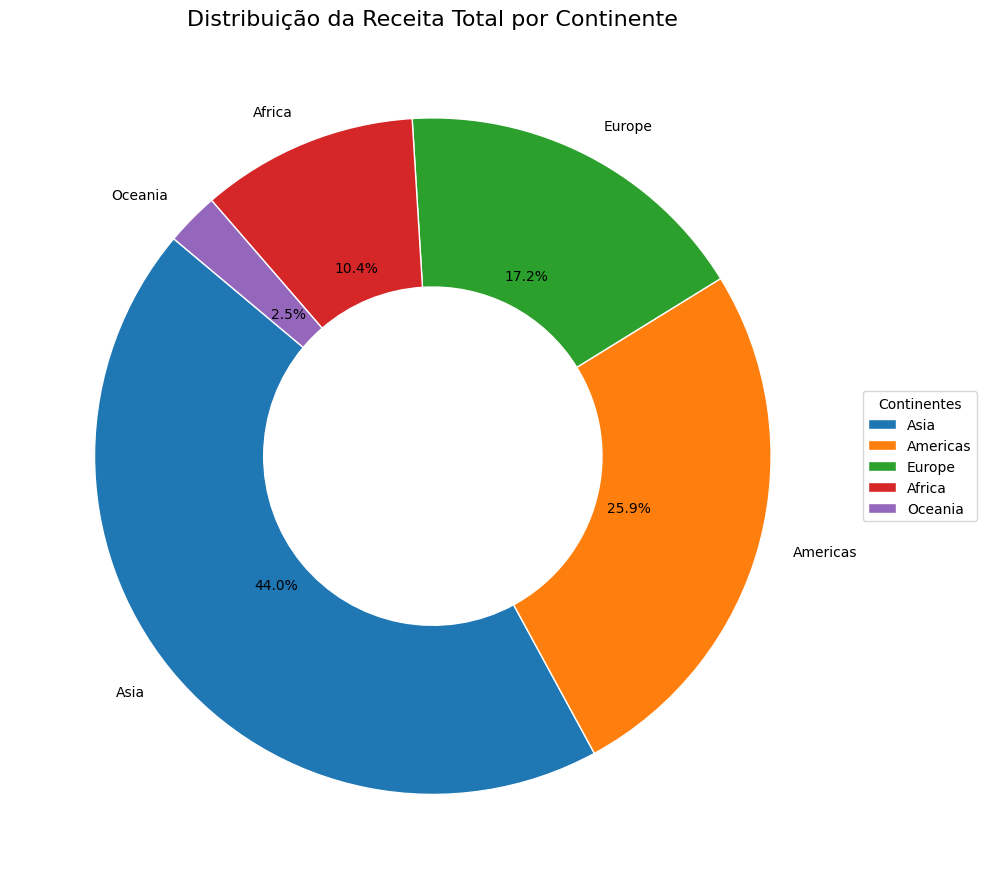

In [14]:
# Exercício 6 – Receita por Continente

print("\n--- Exercício 6: Receita por Continente ---")

# 1. Use a REST Countries API para mapear o continente de cada país.
# Primeiro, pegar todos os países do banco Pagila e sua receita.
query_receita_pais_ex6 = """
SELECT
    co.country AS country_pagila,
    SUM(p.amount) AS receita_total
FROM payment p
JOIN customer cu ON p.customer_id = cu.customer_id
JOIN address a ON cu.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
JOIN country co ON ci.country_id = co.country_id
GROUP BY co.country
ORDER BY co.country;
"""
df_receita_pais_ex6 = run_query(query_receita_pais_ex6)

if not df_receita_pais_ex6.empty:
    print(f"Buscando dados de região (continente) para {len(df_receita_pais_ex6)} países (Ex6)...")
    
    country_region_data = []
    for country_name_pg in df_receita_pais_ex6['country_pagila']:
        data = buscar_dados_pais(country_name_pg) # Usa o cache
        if data and data.get('region'):
            country_region_data.append({
                'country_pagila': country_name_pg,
                'region': data['region'] 
            })
        else:
            country_region_data.append({
                'country_pagila': country_name_pg,
                'region': 'N/A (ou desconhecido)'
            })
            # print(f"Região não encontrada para {country_name_pg}")

    df_paises_com_regiao_ex6 = pd.DataFrame(country_region_data).copy() # <--- ADICIONADO .copy()
    
    # Merge com df_receita_pais
    df_receita_pais_regiao_ex6 = pd.merge(df_receita_pais_ex6, df_paises_com_regiao_ex6, on='country_pagila', how='left')
    df_receita_pais_regiao_ex6.dropna(subset=['region'], inplace=True)
    df_receita_pais_regiao_ex6 = df_receita_pais_regiao_ex6[~df_receita_pais_regiao_ex6['region'].str.contains('N/A', case=False)]

    if not df_receita_pais_regiao_ex6.empty:
        # 2. Agrupe a receita total por continente (region).
        receita_por_continente_ex6 = df_receita_pais_regiao_ex6.groupby('region')['receita_total'].sum().sort_values(ascending=False)
        print("\nReceita total por continente:")
        # print(receita_por_continente_ex6)
        print(tabulate(pd.DataFrame(receita_por_continente_ex6), headers=['Continente', 'Receita Total'], tablefmt="psql"))


        # 3. Exiba os resultados em um gráfico de pizza com matplotlib.
        if not receita_por_continente_ex6.empty:
            plt.figure(figsize=(12, 9)) # Ajustado para melhor visualização
            ax = receita_por_continente_ex6.plot(kind='pie', 
                                                 autopct='%1.1f%%', 
                                                 startangle=140, 
                                                 wedgeprops=dict(width=0.5, edgecolor='w'),
                                                 legend=False) # Desativa legenda automática do pandas para usar plt.legend
            plt.title('Distribuição da Receita Total por Continente', fontsize=16)
            plt.ylabel('') 
            plt.legend(title='Continentes', labels=receita_por_continente_ex6.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
            plt.tight_layout(rect=[0,0,0.8,1]) # Ajustar para legenda não sobrepor
            plt.show()
        else:
            print("Não há dados de receita por continente para plotar.")
    else:
        print("Não foi possível obter dados de receita por região para gerar o gráfico (Ex6).")
else:
    print("Não foi possível obter receita por país (Ex6).")


--- Exercício 7: Tempo Médio de Aluguel vs Clima ---


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)


Buscando clima para 533 cidades (Ex7)...


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\4154494331.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analise_tempo_clima_ex7['temperatura'] = pd.to_numeric(df_analise_tempo_clima_ex7['temperatura'], errors='coerce')
C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\4154494331.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analise_tempo_clima_ex7.dropna(subset=['temperatura'], inplace=True)



Análise de Tempo Médio de Aluguel vs. Temperatura (amostra de cidades):
+----+--------------------+----------------------------+---------------+
|    | city               |   tempo_medio_aluguel_dias |   temperatura |
|----+--------------------+----------------------------+---------------|
|  0 | Abha               |                    5.01196 |          19.2 |
|  1 | Abu Dhabi          |                    4.69066 |          28.2 |
|  2 | A Corua (La Corua) |                    5.48328 |          25.1 |
|  3 | Acua               |                    5.28149 |          23.6 |
|  4 | Adana              |                    5.75406 |          19.2 |
+----+--------------------+----------------------------+---------------+


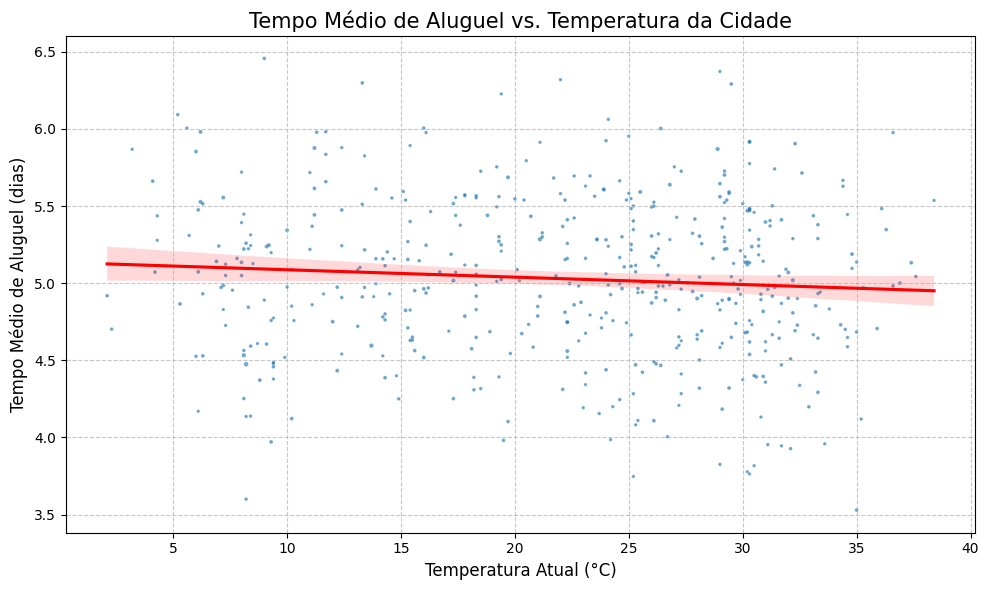


Correlação de Pearson entre temperatura e tempo médio de aluguel: -0.082


In [15]:
# Exercício 7 – Tempo Médio de Aluguel vs Clima

print("\n--- Exercício 7: Tempo Médio de Aluguel vs Clima ---")

# 1. Calcule o tempo médio de aluguel por cidade.
query_tempo_medio_aluguel_cidade = """
SELECT
    ci.city,
    AVG(EXTRACT(EPOCH FROM (r.return_date - r.rental_date))) AS tempo_medio_aluguel_segundos,
    COUNT(r.rental_id) as num_alugueis_cidade
FROM rental r
JOIN customer cu ON r.customer_id = cu.customer_id
JOIN address a ON cu.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
WHERE r.return_date IS NOT NULL
GROUP BY ci.city
HAVING COUNT(r.rental_id) > 20 -- Cidades com pelo menos 20 aluguéis para média mais estável
ORDER BY ci.city;
"""
df_tempo_aluguel_ex7 = run_query(query_tempo_medio_aluguel_cidade)

if not df_tempo_aluguel_ex7.empty:
    df_tempo_aluguel_ex7['tempo_medio_aluguel_dias'] = df_tempo_aluguel_ex7['tempo_medio_aluguel_segundos'] / (60*60*24)
    
    # 2. Combine com a temperatura atual dessas cidades.
    # Amostra ou todas, dependendo da eficiência do cache
    cidades_para_clima_ex7 = df_tempo_aluguel_ex7.copy() # Usar todas as cidades da query
    print(f"Buscando clima para {len(cidades_para_clima_ex7)} cidades (Ex7)...")
    cidades_para_clima_ex7['temperatura'] = cidades_para_clima_ex7['city'].apply(buscar_clima)
    
    df_analise_tempo_clima_ex7 = cidades_para_clima_ex7.dropna(subset=['temperatura', 'tempo_medio_aluguel_dias'])
    df_analise_tempo_clima_ex7['temperatura'] = pd.to_numeric(df_analise_tempo_clima_ex7['temperatura'], errors='coerce')
    df_analise_tempo_clima_ex7.dropna(subset=['temperatura'], inplace=True)
    
    if not df_analise_tempo_clima_ex7.empty:
        print("\nAnálise de Tempo Médio de Aluguel vs. Temperatura (amostra de cidades):")
        print(tabulate(df_analise_tempo_clima_ex7[['city', 'tempo_medio_aluguel_dias', 'temperatura']].head(), headers="keys", tablefmt="psql"))

        # 3. Visualize a correlação.
        if len(df_analise_tempo_clima_ex7) > 1:
            plt.figure(figsize=(10, 6))
            sns.regplot(data=df_analise_tempo_clima_ex7, x='temperatura', y='tempo_medio_aluguel_dias', 
                        scatter_kws={'alpha':0.5, 's': df_analise_tempo_clima_ex7['num_alugueis_cidade']/10}, # Tamanho do ponto pelo num de alugueis
                        line_kws={'color':'red'})
            plt.title('Tempo Médio de Aluguel vs. Temperatura da Cidade', fontsize=15)
            plt.xlabel('Temperatura Atual (°C)', fontsize=12)
            plt.ylabel('Tempo Médio de Aluguel (dias)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            correlacao = df_analise_tempo_clima_ex7['temperatura'].corr(df_analise_tempo_clima_ex7['tempo_medio_aluguel_dias'])
            print(f"\nCorrelação de Pearson entre temperatura e tempo médio de aluguel: {correlacao:.3f}")
            # Comentário sobre a correlação
        else:
            print("Não há dados suficientes (após limpeza e merge) para gerar o gráfico de correlação.")
    else:
        print("Não foi possível obter dados combinados de tempo de aluguel e clima para análise (Ex7).")
else:
    print("Não foram encontrados dados de tempo médio de aluguel para as cidades (Ex7).")

In [16]:
# Exercício 8 – Perfil de Clima por Cliente

print("\n--- Exercício 8: Perfil de Clima por Cliente ---")

# 1. Para cada cliente, crie um perfil com: cidade, temperatura, AQI, total de aluguéis, gasto total.
query_perfil_cliente_base_ex8 = """
SELECT
    c.customer_id,
    c.first_name,
    c.last_name,
    ci.city,
    a.district, -- Para AQI
    cy.country AS country_pagila, -- Para AQI e Temperatura
    COUNT(r.rental_id) AS total_alugueis,
    COALESCE(SUM(p.amount), 0) AS gasto_total -- COALESCE para clientes sem pagamentos
FROM customer c
JOIN address a ON c.address_id = a.address_id
JOIN city ci ON a.city_id = ci.city_id
JOIN country cy ON ci.country_id = cy.country_id
LEFT JOIN rental r ON c.customer_id = r.customer_id
LEFT JOIN payment p ON r.rental_id = p.rental_id
GROUP BY c.customer_id, c.first_name, c.last_name, ci.city, a.district, cy.country
ORDER BY c.customer_id;
"""
df_perfil_cliente_base_ex8 = run_query(query_perfil_cliente_base_ex8)

if not df_perfil_cliente_base_ex8.empty:
    # Para enriquecer com Temp e AQI, precisamos de uma lista de cidades únicas.
    df_cidades_unicas_clientes_ex8 = df_perfil_cliente_base_ex8[['city', 'district', 'country_pagila']].drop_duplicates().reset_index(drop=True)
    
    # AMOSTRAGEM FORTE para demonstração, pois buscar AQI/Temp para todas as cidades de todos os clientes pode ser muito longo.
    # Ajuste SAMPLE_SIZE conforme a eficiência do seu cache e paciência.
    SAMPLE_SIZE_CITIES_EX8 = min(30, len(df_cidades_unicas_clientes_ex8)) 
    df_cidades_amostra_ex8 = df_cidades_unicas_clientes_ex8.sample(n=SAMPLE_SIZE_CITIES_EX8, random_state=123) \
        if len(df_cidades_unicas_clientes_ex8) > SAMPLE_SIZE_CITIES_EX8 else df_cidades_unicas_clientes_ex8.copy()

    print(f"\nBuscando dados ambientais para uma AMOSTRA de {len(df_cidades_amostra_ex8)} cidades de clientes (Ex8)...")
    
    # Reutilizar country_name_map_airvisual do Ex4
    country_name_map_airvisual_ex8 = country_name_map_airvisual 
    
    city_env_data = []
    for _, row in df_cidades_amostra_ex8.iterrows():
        cidade = row['city']
        distrito = row['district']
        pais_pagila = row['country_pagila']
        pais_api_aqi = country_name_map_airvisual_ex8.get(pais_pagila, pais_pagila)

        temp = buscar_clima(cidade)
        aqi_val = None
        if AIRVISUAL_API_KEY:
            aqi_val = buscar_aqi_cidade(cidade, distrito, pais_api_aqi)
            if aqi_val is None and (distrito.lower() == cidade.lower() or len(distrito.split()) > 2 or distrito in ['N/A', '']):
                 aqi_val = buscar_aqi_cidade(cidade, cidade, pais_api_aqi)
        
        city_env_data.append({
            'city': cidade, 'district': distrito, 'country_pagila': pais_pagila, # Chaves para merge
            'temperatura': temp, 'aqi': aqi_val
        })
    
    df_city_env_ex8 = pd.DataFrame(city_env_data)
    df_city_env_ex8['temperatura'] = pd.to_numeric(df_city_env_ex8['temperatura'], errors='coerce')
    df_city_env_ex8['aqi'] = pd.to_numeric(df_city_env_ex8['aqi'], errors='coerce')

    # Merge dos dados ambientais (da amostra de cidades) de volta ao perfil do cliente
    df_perfil_cliente_enriquecido_ex8 = pd.merge(
        df_perfil_cliente_base_ex8,
        df_city_env_ex8,
        on=['city', 'district', 'country_pagila'],
        how='inner' # 'inner' para pegar apenas clientes das cidades amostradas com dados ambientais
    )
    
    if not df_perfil_cliente_enriquecido_ex8.empty:
        print("\nPerfil de Clima por Cliente (amostra de clientes em cidades amostradas):")
        cols_perfil = ['customer_id', 'first_name', 'city', 'temperatura', 'aqi', 'total_alugueis', 'gasto_total']
        print(tabulate(df_perfil_cliente_enriquecido_ex8[cols_perfil].head(), headers="keys", tablefmt="psql"))

        # 2. Agrupe os perfis por faixa etária (simulada) e avalie padrões.
        np.random.seed(42) 
        faixas_etarias_simuladas = ['18-29', '30-45', '46-59', '60+']
        df_perfil_cliente_enriquecido_ex8.loc[:, 'faixa_etaria_simulada'] = np.random.choice(
            faixas_etarias_simuladas, size=len(df_perfil_cliente_enriquecido_ex8), p=[0.3, 0.35, 0.25, 0.1]
        )

        print("\nAnálise de padrões por Faixa Etária Simulada (amostra):")
        
        # Gasto total médio por faixa etária
        gasto_por_faixa = df_perfil_cliente_enriquecido_ex8.groupby('faixa_etaria_simulada')['gasto_total'].mean().sort_values(ascending=False)
        print("\nGasto Total Médio por Faixa Etária Simulada:")
        print(tabulate(pd.DataFrame(gasto_por_faixa), headers=['Faixa Etária', 'Gasto Médio'], tablefmt="psql"))

        if 'aqi' in df_perfil_cliente_enriquecido_ex8.columns and not df_perfil_cliente_enriquecido_ex8['aqi'].isnull().all():
            df_perfil_cliente_enriquecido_ex8.loc[:, 'qualidade_ar'] = pd.cut(
                df_perfil_cliente_enriquecido_ex8['aqi'], bins=[0, 50, 100, 150, np.inf],
                labels=['Boa (0-50)', 'Moderada (51-100)', 'Ruim (101-150)', 'Muito Ruim (>150)'], right=True, include_lowest=True
            )
            gasto_faixa_aqi = df_perfil_cliente_enriquecido_ex8.groupby(['faixa_etaria_simulada', 'qualidade_ar'], observed=False)['gasto_total'].mean().unstack()
            print("\nGasto Total Médio por Faixa Etária e Qualidade do Ar (AQI):")
            print(tabulate(gasto_faixa_aqi.fillna(0), headers="keys", tablefmt="psql"))
        else:
            print("\nDados de AQI não disponíveis ou insuficientes para análise por qualidade do ar.")

        print("\nObjetivo (Exercício 8): Conectar comportamento de consumo e ambiente (exemplificado).")
        print("Análise mais profunda requereria dados reais de faixa etária e um conjunto de dados ambientais mais completo.")
    else:
        print("Não há dados de perfil de cliente (após amostragem e merge com dados ambientais) para análise (Ex8).")
else:
    print("Não foi possível obter dados base de perfil de cliente (Ex8).")


--- Exercício 8: Perfil de Clima por Cliente ---


C:\Users\dgeis\AppData\Local\Temp\ipykernel_24748\720489529.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, db_conn)



Buscando dados ambientais para uma AMOSTRA de 30 cidades de clientes (Ex8)...

Perfil de Clima por Cliente (amostra de clientes em cidades amostradas):
+----+---------------+--------------+--------------+---------------+-------+------------------+---------------+
|    |   customer_id | first_name   | city         |   temperatura |   aqi |   total_alugueis |   gasto_total |
|----+---------------+--------------+--------------+---------------+-------+------------------+---------------|
|  0 |            12 | NANCY        | Yamuna Nagar |          30.7 |   nan |               28 |        103.72 |
|  1 |            36 | KATHLEEN     | Arak         |          20.8 |   nan |               27 |         92.73 |
|  2 |            49 | JOYCE        | Jedda        |          29.1 |   nan |               28 |        130.72 |
|  3 |            55 | DORIS        | Balaiha      |         nan   |   nan |               22 |        100.78 |
|  4 |            67 | KELLY        | Xiangtan     |          2

In [17]:
# Exercício 9 – Exportação Inteligente

print("\n--- Exercício 9: Exportação Inteligente para Excel ---")

# Usar df_perfil_cliente_enriquecido_ex8 se disponível e não vazio.
# Este DataFrame já contém customer_id, cidade, país, temperatura, aqi, gasto_total para uma amostra.
if 'df_perfil_cliente_enriquecido_ex8' in locals() and not df_perfil_cliente_enriquecido_ex8.empty:
    df_para_exporte_ex9 = df_perfil_cliente_enriquecido_ex8.copy()
    
    # Garantir que colunas numéricas são de fato numéricas
    df_para_exporte_ex9['temperatura'] = pd.to_numeric(df_para_exporte_ex9['temperatura'], errors='coerce')
    df_para_exporte_ex9['aqi'] = pd.to_numeric(df_para_exporte_ex9['aqi'], errors='coerce')
    df_para_exporte_ex9['gasto_total'] = pd.to_numeric(df_para_exporte_ex9['gasto_total'], errors='coerce')

    # Calcular média geral de receita (gasto total) da amostra disponível
    media_geral_receita_ex9 = df_para_exporte_ex9['gasto_total'].mean()
    print(f"Média geral de receita (gasto total por cliente na amostra para Ex9): ${media_geral_receita_ex9:,.2f}")

    # Aplicar filtros:
    # 1. Clientes de cidades com temperatura < 15°C
    # 2. AQI da cidade acima de 100
    # 3. Gasto total individual > média geral (da amostra)
    
    # Lidar com NaNs antes de filtrar
    df_para_exporte_ex9_com_filtros = df_para_exporte_ex9.dropna(subset=['temperatura', 'aqi', 'gasto_total'])

    df_filtrado_export_ex9 = df_para_exporte_ex9_com_filtros[
        (df_para_exporte_ex9_com_filtros['temperatura'] < 15) &
        (df_para_exporte_ex9_com_filtros['aqi'] > 100) &
        (df_para_exporte_ex9_com_filtros['gasto_total'] > media_geral_receita_ex9)
    ]
    
    print(f"\nNúmero de clientes (da amostra) que atendem aos critérios de exportação: {len(df_filtrado_export_ex9)}")

    if not df_filtrado_export_ex9.empty:
        df_clientes_aba = df_filtrado_export_ex9[['customer_id', 'first_name', 'last_name', 'city', 'country_pagila', 'gasto_total']].copy()
        df_temperaturas_aba = df_filtrado_export_ex9[['customer_id', 'city', 'country_pagila', 'temperatura']].copy()
        df_alertas_aba = df_filtrado_export_ex9[['customer_id', 'city', 'country_pagila', 'aqi', 'temperatura', 'gasto_total']].copy()
        df_alertas_aba.loc[:, 'alerta_motivo'] = "Temp<15 & AQI>100 & Gasto>Média"

        excel_filename = "relatorio_clientes_criticos.xlsx"
        try:
            with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
                df_clientes_aba.to_excel(writer, sheet_name='Clientes_Criticos', index=False)
                df_temperaturas_aba.to_excel(writer, sheet_name='Condicoes_Temperatura', index=False)
                df_alertas_aba.to_excel(writer, sheet_name='Alertas_Ambientais_Consumo', index=False)
            print(f"\nRelatório '{excel_filename}' gerado com sucesso com {len(df_filtrado_export_ex9)} clientes.")
        except Exception as e:
            print(f"Erro ao gerar o arquivo Excel: {e}. Verifique se 'openpyxl' está instalado.")
    else:
        print("\nNenhum cliente (da amostra) atendeu a todos os critérios para o relatório Excel.")
        if not AIRVISUAL_API_KEY:
            print("Lembrete: A coluna AQI pode estar incompleta se a chave AIRVISUAL_KEY não foi configurada, afetando o filtro.")
        if df_para_exporte_ex9.empty or df_para_exporte_ex9_com_filtros.empty :
             print("O DataFrame base para exportação estava vazio ou ficou vazio após remoção de NaNs nos campos de filtro.")

else:
    print("DataFrame 'df_perfil_cliente_enriquecido_ex8' não disponível ou vazio. Pulando Exercício 9.")
    print("Execute o Exercício 8 para gerar os dados necessários para este relatório.")


--- Exercício 9: Exportação Inteligente para Excel ---
Média geral de receita (gasto total por cliente na amostra para Ex9): $113.00

Número de clientes (da amostra) que atendem aos critérios de exportação: 0

Nenhum cliente (da amostra) atendeu a todos os critérios para o relatório Excel.


In [18]:
# Exercício 10 – API Cache Inteligente (Desafio)
# A implementação do cache já foi integrada nas funções de busca de API.
# Esta célula serve para demonstrar e testar o cache.

print("\n--- Exercício 10: Demonstração do Cache Inteligente ---")
print("O sistema de cache (CSV) foi implementado e integrado nas funções:")
print("  - buscar_clima() (para WeatherAPI)")
print("  - buscar_aqi_cidade() (para AirVisual API)")
print("  - buscar_dados_pais() (para REST Countries API)")
print("Os arquivos de cache são salvos/lidos do diretório 'api_cache'.")

# Demonstração de uso das funções com cache:
print("\nTestando buscar_clima() com cache:")
print(f"Clima para 'London' (1ª vez - pode ser API call ou cache hit se já executado): {buscar_clima('London')}")
print(f"Clima para 'London' (2ª vez - deve ser CACHE HIT): {buscar_clima('London')}")
print(f"Clima para 'Tokyo' (1ª vez): {buscar_clima('Tokyo')}")
print(f"Clima para 'Tokyo' (2ª vez - CACHE HIT): {buscar_clima('Tokyo')}")

if AIRVISUAL_API_KEY:
    print("\nTestando buscar_aqi_cidade() com cache (requer AIRVISUAL_KEY):")
    # Use uma cidade/estado/país válidos para teste
    print(f"AQI para 'Beijing', 'Beijing', 'China' (1ª vez): {buscar_aqi_cidade('Beijing', 'Beijing', 'China')}")
    print(f"AQI para 'Beijing', 'Beijing', 'China' (2ª vez - CACHE HIT): {buscar_aqi_cidade('Beijing', 'Beijing', 'China')}")
    print(f"AQI para 'Paris', 'Ile-de-France', 'France' (1ª vez): {buscar_aqi_cidade('Paris', 'Ile-de-France', 'France')}") # Exemplo, pode precisar ajustar estado/país
    print(f"AQI para 'Paris', 'Ile-de-France', 'France' (2ª vez - CACHE HIT): {buscar_aqi_cidade('Paris', 'Ile-de-France', 'France')}")
else:
    print("\nTeste de cache AQI PULADO: Chave AIRVISUAL_KEY não configurada no .env.")

print("\nTestando buscar_dados_pais() com cache:")
print(f"Dados para 'Brazil' (1ª vez): {buscar_dados_pais('Brazil')}")
print(f"Dados para 'Brazil' (2ª vez - CACHE HIT): {buscar_dados_pais('Brazil')}")
print(f"Dados para 'Germany' (1ª vez): {buscar_dados_pais('Germany')}")
print(f"Dados para 'Germany' (2ª vez - CACHE HIT): {buscar_dados_pais('Germany')}")

print("\n--- Fim da Demonstração do Cache ---")
print("Ao reexecutar os exercícios anteriores, as chamadas de API para os mesmos parâmetros devem ser servidas pelo cache, tornando a execução mais rápida.")


--- Exercício 10: Demonstração do Cache Inteligente ---
O sistema de cache (CSV) foi implementado e integrado nas funções:
  - buscar_clima() (para WeatherAPI)
  - buscar_aqi_cidade() (para AirVisual API)
  - buscar_dados_pais() (para REST Countries API)
Os arquivos de cache são salvos/lidos do diretório 'api_cache'.

Testando buscar_clima() com cache:
Clima para 'London' (1ª vez - pode ser API call ou cache hit se já executado): 8.1
Clima para 'London' (2ª vez - deve ser CACHE HIT): 8.1
Clima para 'Tokyo' (1ª vez): 29.2
Clima para 'Tokyo' (2ª vez - CACHE HIT): 29.2

Testando buscar_aqi_cidade() com cache (requer AIRVISUAL_KEY):
AQI para 'Beijing', 'Beijing', 'China' (1ª vez): None
AQI para 'Beijing', 'Beijing', 'China' (2ª vez - CACHE HIT): None
AQI para 'Paris', 'Ile-de-France', 'France' (1ª vez): None
AQI para 'Paris', 'Ile-de-France', 'France' (2ª vez - CACHE HIT): None

Testando buscar_dados_pais() com cache:
Dados para 'Brazil' (1ª vez): {'name_common': 'Brazil', 'name_official'

In [19]:
# Fechar Conexão com o Banco (Opcional, no final do notebook)
if conn:
    cur.close()
    conn.close()
    print("\nConexão com o PostgreSQL fechada.")


Conexão com o PostgreSQL fechada.
